# Model Validation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

## Objectives

- **Explain** the bias-variance tradeoff and the correlative notions of underfit and overfit models
- **Describe** a train-test split and **explain** its purpose in the context of predictive statistics / machine learning
- **Explain** the algorithm of cross-validation

## Motivation

At this point, we have seen different ways to create models from our data through different linear regression techniques. That's good. But when it comes to measuring model performance, we also want to make sure that our models are ready to predict on data that they haven't seen yet.

Usually, when our model is ready to be used in the "real world" we refer to this as putting our model into **production** or **deploying** our model. The data points for which it will make predictions will be data *it has never seen before*, as opposed to the data points that were used to train the model.

This is where ***model validation*** techniques come in, namely, to ensure our model can *generalize* to data it hasn't directly seen before.

As a way into a discussion of these techniques let's say a word about the **bias-variance tradeoff**.

# The Bias-Variance Tradeoff

## A Model Example

Typically we'll talk about a model in terms of how _complex_ it is in making predictions.

Let's take a look at this data with just one feature and a target:

<!--TODO: Replace with a dataset and code -->
![](https://camo.githubusercontent.com/36a1cb13983f39fc58ecdfffb415b2258e73ba1c/68747470733a2f2f6769746875622e636f6d2f6c6561726e2d636f2d73747564656e74732f6473632d322d32342d30372d626961732d76617269616e63652d74726164652d6f66662d6f6e6c696e652d64732d73702d3030302f7261772f6d61737465722f696e6465785f66696c65732f696e6465785f375f312e706e67)

We can probably picture how a good model will fit to this data. Let's look at a couple models and discuss how they're making mistakes.

### Model A

![](images/model_simple.png)

What do we observe here? How would you describe where the model is failing? Too simple

### Model B

![](images/model_complex.png)

What do we observe here? How would you describe where the model is failing? high variance over fit

## High-Bias vs High-Variance

We can break up how the model makes mistakes (the error) by saying there are three parts:

- Error inherent in the data (noise): **irreducible error**
- Error from not capturing signal (too simple): **bias**
- Error from "modeling noise", i.e. capturing patterns in the data that don't generalize well (too complex): **variance**

We can summarize this in an equation for the _mean squared error_ (MSE):

$MSE = Bias(\hat{y})^2 + Var(\hat{y}) + \sigma^2$

![optimal](images/optimal_bias_variance.png)
http://scott.fortmann-roe.com/docs/BiasVariance.html

### Bias

**High-bias** algorithms tend to be less complex, with simple or rigid underlying structure.

![](images/noisy-sine-linear.png)

+ They train models that are consistent, but inaccurate on average.
+ These include linear or parametric algorithms such as regression and naive Bayes.
+ The following sorts of difficulties could lead to high bias:
  - We did not include the correct predictors
  - We did not take interactions into account
  - We missed a non-linear (polynomial) relationship

      
High-bias models are generally **underfit**: The models have not picked up enough of the signal in the data. And so even though they may be consistent, they don't perform particularly well on the initial data, and so they will be consistently inaccurate.

### Variance

On the other hand, **high-variance** algorithms tend to be more complex, with flexible underlying structure.

![](images/noisy-sine-decision-tree.png)

+ They train models that are accurate on average, but inconsistent.
+ These include non-linear or non-parametric algorithms such as decision trees and nearest-neighbor models.
+ The following sorts of difficulties could lead to high variance:
  - We included an unreasonably large number of predictors;
  - We created new features by squaring and cubing each feature.

High variance models are **overfit**: The models have picked up on the noise as well as the signal in the data. And so even though they may perform well on the initial data, they will be inconsistently accurate on new data.

### Balancing Bias and Variance

While we build our models, we have to keep this relationship in mind.  If we build complex models, we risk overfitting our models.  Their predictions will vary greatly when introduced to new data.  If our models are too simple, the predictions as a whole will be inaccurate.   

![](images/noisy-sine-third-order-polynomial.png)

The goal is to build a model with enough complexity to be accurate, but not too much complexity to be erratic.

![](images/target.png)

## Different Models for King County Housing Data

In [6]:
# For consistent randomness
np.random.seed(42)

In [7]:
df = pd.read_csv('data/king_county.csv', index_col='id')
display(df.shape)
df.head()

(21613, 12)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0


Let's take a random data point that we can use for prediction. Note the trained model will never see this point until after it's done training.

In [10]:
my_sample_price

365000.0

In [9]:
my_sample = df.sample(1)
my_sample_price = my_sample.iloc[0, 0]
my_sample_pt = my_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${my_sample_price}')
my_sample_pt

Price of sample: $365000.0


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,
2591820310,4,2.25,2070,8893,2.0,0,0,4,8,2070,0


Now let's generate random subsets of our data now to train different models and see how well they do in predicting  that random point

In [11]:
def train_lr_randomly(data, sample_pt=None, ntimes=100):
    '''
    Takes in features & targets from `data` to train a linear regression with a
    random sample `ntimes`. It then returns a list of R2 scores, RMSEs, and the 
    predictions from a provided data point of features `sample_pt`.
    '''
    # To save all of our predictions
    r2 = []
    rmse = []
    # Only return predictions if there is something to predict (sample_pt given)
    point_preds = [] if (sample_pt is not None) else None

    # We'll repeat this little experiment to see how the model does
    for i in range(ntimes):
        # Creating a random sample of data to train on
        df_sample = data.sample(5000, replace=True)
        y = df_sample.price
        X = df_sample.drop('price', axis=1)

        # Our linear regression model about to be trained
        lr = LinearRegression()
        lr.fit(X, y)

        # Making predictions & evaluating on the data we used to train the model
        y_hat = lr.predict(X)
        rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
        r2.append(lr.score(X, y))

        # Making a prediction on the one point the model definitely never saw
        if sample_pt is not None:
            y_hat_pt = lr.predict(sample_pt)
            # Getting just the single point to add into list
            point_preds.append(y_hat_pt[0])
    
    return r2, rmse, point_preds

In [12]:
# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_simple, rmse_simple, pt_preds_simple = train_lr_randomly(
                                                        data=df.drop(my_sample_pt.index[0]), 
                                                        sample_pt=my_sample_pt,
                                                        ntimes=100                            
)

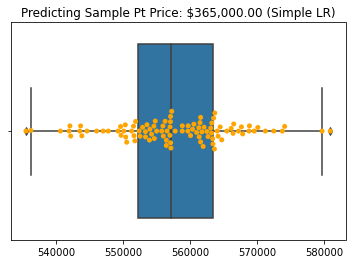

In [13]:
ax = sns.boxplot(x=pt_preds_simple);
ax = sns.swarmplot(x=pt_preds_simple, color='orange', ax=ax)
ax.set_title(f'Predicting Sample Pt Price: ${my_sample_price:,.2f} (Simple LR)');

Now let's see how we do with a more complex model (using polynomial features):

In [14]:
df = pd.read_csv('data/king_county.csv', index_col='id')

pf = PolynomialFeatures(2) # What if we used 3 or 4?

df_pf = pd.DataFrame(pf.fit_transform(df.drop('price', axis=1)))
df_pf.index = df.index
df_pf['price'] = df['price']

cols = list(df_pf)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('price')))

df_pf = df_pf.loc[:, cols]

df_pf.head(10)

,price,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,76,77
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,1.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,...,9.0,21.0,3540.0,0.0,49.0,8260.0,0.0,1392400.0,0.0,0.0
6414100192,538000.0,1.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,...,9.0,21.0,6510.0,1200.0,49.0,15190.0,2800.0,4708900.0,868000.0,160000.0
5631500400,180000.0,1.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,...,9.0,18.0,2310.0,0.0,36.0,4620.0,0.0,592900.0,0.0,0.0
2487200875,604000.0,1.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,...,25.0,35.0,5250.0,4550.0,49.0,7350.0,6370.0,1102500.0,955500.0,828100.0
1954400510,510000.0,1.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,...,9.0,24.0,5040.0,0.0,64.0,13440.0,0.0,2822400.0,0.0,0.0
7237550310,1225000.0,1.0,4.0,4.50,5420.0,101930.0,1.0,0.0,0.0,3.0,...,9.0,33.0,11670.0,4590.0,121.0,42790.0,16830.0,15132100.0,5951700.0,2340900.0
1321400060,257500.0,1.0,3.0,2.25,1715.0,6819.0,2.0,0.0,0.0,3.0,...,9.0,21.0,5145.0,0.0,49.0,12005.0,0.0,2941225.0,0.0,0.0
2008000270,291850.0,1.0,3.0,1.50,1060.0,9711.0,1.0,0.0,0.0,3.0,...,9.0,21.0,3180.0,0.0,49.0,7420.0,0.0,1123600.0,0.0,0.0
2414600126,229500.0,1.0,3.0,1.00,1780.0,7470.0,1.0,0.0,0.0,3.0,...,9.0,21.0,3150.0,2190.0,49.0,7350.0,5110.0,1102500.0,766500.0,532900.0


In [15]:
# Let's make sure we have another sample point to test our models
my_sample_pt_poly = pf.transform(my_sample_pt)
my_sample_pt_poly = pd.DataFrame(my_sample_pt_poly,
                                index=my_sample_pt.index)

# Show my random sample off
print(f'Price of sample: ${my_sample_price}')
my_sample_pt_poly.shape

Price of sample: $365000.0


(1, 78)

In [16]:
# Run 100 linear regression trainings on some random polynomial features data
# from df_poly and compare it with the random sample point
r2_poly, rmse_poly, pt_preds_poly = train_lr_randomly(
                                                data=df_pf.drop(my_sample_pt_poly.index[0]), 
                                                sample_pt=my_sample_pt_poly,
                                                ntimes=100                            
)

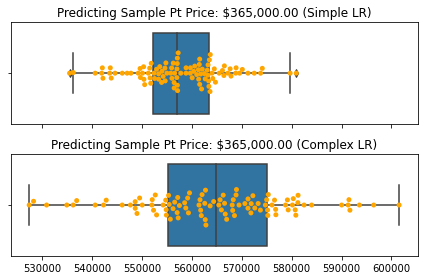

In [17]:
f, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,4));

# Simple model
ax = sns.boxplot(x=pt_preds_simple, ax=ax1);
ax = sns.swarmplot(x=pt_preds_simple, color='orange', ax=ax)
ax.set_title(f'Predicting Sample Pt Price: ${my_sample_price:,.2f} (Simple LR)');

# Complex model
ax = sns.boxplot(x=pt_preds_poly, ax=ax2);
ax = sns.swarmplot(x=pt_preds_poly, color='orange', ax=ax)
ax.set_title(f'Predicting Sample Pt Price: ${my_sample_price:,.2f} (Complex LR)');

# Makes spacing work better
f.tight_layout()

In [18]:
print('How it did on its own training data:')
print(f'\t- simple model mean RMSE {np.mean(rmse_simple)}')
print(f'\t- complex model mean RMSE {np.mean(rmse_poly)}')
print('\n')

print('How it did on data it never saw:')
print(f'\t- simple model predictions\' std {np.std(pt_preds_simple)}')
print(f'\t- complex model predictions\' std {np.std(pt_preds_poly)}')

How it did on its own training data:
	- simple model mean RMSE 228616.49189481483
	- complex model mean RMSE 201301.8165134862


How it did on data it never saw:
	- simple model predictions' std 8742.869878582664
	- complex model predictions' std 14933.893175930256


## 🧠 Knowledge Check

![which_model](images/which_model_is_better_2.png)

# Train-Test Split

It is hard to know if your model is too simple or complex by just using it on training data.

We can _hold out_ part of our training sample, use it as a test sample, and then use it to monitor our prediction error.

This allows us to evaluate whether our model has the right balance of bias/variance. 

<img src='images/testtrainsplit.png' width =550 />

* **training set** —a subset to train a model.
* **test set**—a subset to test the trained model.

In [19]:
df = pd.read_csv('data/king_county.csv', index_col='id')

y = df.price
X = df[['bedrooms', 'sqft_living']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=None,
                                                    random_state=42
)

In [20]:
display(X_train.head())
display(X_test.head())

,bedrooms,sqft_living
id,,
9117000170,4,1810
6700390210,3,1600
7212660540,4,1720
8562780200,2,1240
7760400350,3,1280


,bedrooms,sqft_living
id,,
2591820310,4,2070
7974200820,5,2900
7701450110,4,3770
9522300010,3,4560
9510861140,3,2550


In [21]:
print(X_train.shape)
print(X_test.shape)

print(X_train.shape[0] == y_train.shape[0])
print(X_test.shape[0] == y_test.shape[0])

(16209, 2)
(5404, 2)
True
True


## Is the Model Overfitting or Underfitting?

If our model is not performing well on the training  data, we are probably underfitting it.  

To know if our  model is overfitting the data, we need  to test our model on unseen data. 
We then measure our performance on the unseen data. 

If the model performs significantly worse on the  unseen data, it is probably  overfitting the data.

<img src='https://developers.google.com/machine-learning/crash-course/images/WorkflowWithTestSet.svg' width=500/>

## Exercise: Name that Model!

Consider the following scenarios and describe them according to bias and variance. There are four possibilities:

- a. The model has low bias and high variance.
- b. The model has high bias and low variance.
- c. The model has both low bias and low variance.
- d. The model has both high bias and high variance.

**Scenario 1**: The model has a low RMSE on training and a low RMSE on test.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>

**Scenario 2**: The model has a high $R^2$ on the training set, but a low $R^2$ on the test.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>

**Scenario 3**: The model performs well on data it is fit on and well on data it has not seen.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>
  

**Scenario 4**: The model has a low $R^2$ on training but high on the test set.
<details>
    <summary> Answer
    </summary>
    d. The model has both high bias and high variance.
    </details>

**Scenario 5**: The model leaves out many of the meaningful predictors, but is consistent across samples.
<details>
    <summary> Answer
    </summary>
    b. The model has high bias and low variance.
    </details>

**Scenario 6**: The model is highly sensitive to random noise in the training set.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>

## Should You Ever Fit on Your Test Set?  

![no](https://media.giphy.com/media/d10dMmzqCYqQ0/giphy.gif)

**Never fit on test data.** If you are seeing surprisingly good results on your evaluation metrics, it might be a sign that you are accidentally training on the test set.

## Train-Test Split Our Earlier Example

Let's go back to our KC housing data without the polynomial transformation.

In [22]:
df = pd.read_csv('data/king_county.csv', index_col='id')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0


Now, we create a train-test split via the `sklearn.model_selection` package.

In [23]:
y = df.price
X = df[['bedrooms', 'sqft_living']]

# Here is the convention for a traditional train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [24]:
# Instanstiate your linear regression object
lr = LinearRegression()

In [25]:
# fit the model on the training set
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
# Check the R^2 of the training data
lr.score(X_train, y_train)

0.5059385369004967

In [27]:
lr.coef_

array([-55228.54258621,    312.15699349])

A .506 R-squared reflects a model that explains about half of the total variance in the data. 

## Now check performance on test data

Next, we test how well the model performs on the unseen test data. Remember, we do not fit the model again. The model has calculated the optimal parameters learning from the training set.  

In [28]:
lr.score(X_test, y_test)

0.5093504668464703

## 🧠 Knowledge Check

How would you describe the bias of the model based on the above training $R^2$?

<details>
    <summary> Answer
    </summary>
    The difference between the train and test scores is low.
    </details>

What does that indicate about variance? low variance

## Same Procedure with a Polynomial Model

In [29]:
df = pd.read_csv('data/king_county.csv', index_col='id')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0


In [30]:
poly_2 = PolynomialFeatures(4)

X_poly = pd.DataFrame(
            poly_2.fit_transform(df.drop('price', axis=1))
                      )

y = df.price
X_poly.head()

,0,1,2,3,4,5,6,7,8,9,...,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364
0,1.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,...,0.0,1.150122e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.938778e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,...,7840000.0,7.152819e+10,1.318492e+10,2.430400e+09,4.480000e+08,2.217374e+13,4.087325e+12,7.534240e+11,1.388800e+11,2.560000e+10
2,1.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,...,0.0,2.739198e+09,0.000000e+00,0.000000e+00,0.000000e+00,3.515304e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,...,40576900.0,8.103375e+09,7.022925e+09,6.086535e+09,5.274997e+09,1.215506e+12,1.053439e+12,9.129802e+11,7.912496e+11,6.857496e+11
4,1.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,...,0.0,3.793306e+10,0.000000e+00,0.000000e+00,0.000000e+00,7.965942e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y,
                                                    test_size=0.2,
                                                    random_state=42)
lr_poly = LinearRegression()

# Always fit on the training set
lr_poly.fit(X_train, y_train)

lr_poly.score(X_train, y_train)

0.6681730794314075

In [32]:
lr_poly.score(X_test, y_test)

-62.74519030488924

## Exercise

[This post about scaling and data leakage](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data) explains that if you are going to scale your data, you should only train your scaler on the training data to prevent data leakage.  

Perform the same train-test split as shown above for the simple model, but now scale your data appropriately.  

The $R^2$ for both train and test should be the same as before.

In [33]:
np.random.seed(42)

y = df.price
X = df[['bedrooms', 'sqft_living']]

# Train test split with random_state=42 and test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create (reasonable) polynomial features
pf = PolynomialFeatures(1).fit(X_train)
pf_train = pf.transform(X_train)

# Scale appropriately
ss = StandardScaler().fit(pf_train)
train_scld = ss.transform(pf_train)

# fit and score the model (checkout the test set if there is time)
lr = LinearRegression().fit(train_scld, y_train)
print(lr.score(train_scld, y_train))
pf_test = pf.transform(X_test)
test_scld = ss.transform(pf_test)
print(lr.score(test_scld, y_test))

0.5059385369004967
0.5093504668464703


<details>
    <summary>Answer</summary>
<code>np.random.seed(42)
y = df.price
X = df[['bedrooms', 'sqft_living']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
pf = PolynomialFeatures(1).fit(X_train)
pf_train = pf.transform(X_train)
ss = StandardScaler().fit(pf_train)
train_scld = ss.transform(pf_train)
lr = LinearRegression().fit(train_scld, y_train)
print(lr.score(train_scld, y_train))
pf_test = pf.transform(X_test)
test_scld = ss.transform(pf_test)
print(lr.score(test_scld, y_test))
</code>
    </details>

## Level Up: $k$-Fold Cross-Validation: Even More Rigorous Validation  

Our goal of using a test set is to simulate what happens when our model attempts predictions on data it's never seen before. But it's possible that our model would *by chance* perform well on the test set.

This is where we could use a more rigorous validation method and turn to **$k$-fold cross-validation**.

![kfolds](images/k_folds.png)

[image via sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)

In this process, we split the dataset into a train set and holdout test sets like usual by performing a shuffling train-test split on the train set.  

We then do $k$-number of _folds_ of the training data. This means we divide the training set into different sections or folds. We then take turns on using each fold as a **validation set** (or **dev set**) and train on the larger fraction. Then we calculate a validation score from the validation set the model has never seen. We repeat this process until each fold has served as a validation set.

This process allows us to try out training our model and check to see if it is likely to overfit or underfit without touching the holdout test data set.

If we think the model is looking good according to our cross-validation using the training data, we retrain the model using all of the training data. Then we can do one final evaluation using the test data. 

It's important that we hold onto our test data until the end and refrain from making adjustments to the model based on the test results.

## Example

In [34]:
X = df.drop('price', axis=1)
y = df.price

In [35]:
# Let's create our holdout test
X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y,
                                                test_size=0.2,
                                                random_state=42
)

### Simple Model

In [36]:
model_simple = LinearRegression()
scores_simple = cross_validate(
                    model_simple, X_train, y_train, cv=5, 
                    return_train_score=True
)
print(f"""train scores: {scores_simple['train_score']},
      test scores: {scores_simple['test_score']}""")

train scores: [0.60608408 0.60542007 0.59746541 0.59886644 0.60586444],
      test scores: [0.58939675 0.59024623 0.62247064 0.61815269 0.58479733]


In [37]:
# Mean train r_2
np.mean(scores_simple['train_score']), np.std(scores_simple['train_score'])

(0.6027400889129975, 0.0037670560670530983)

In [38]:
# Mean test r_2
np.mean(scores_simple['test_score']), np.std(scores_simple['test_score'])

(0.6010127304502688, 0.015924871739074215)

In [39]:
# Fit on all the training data
model_simple.fit(X_train, y_train)
model_simple.score(X_train, y_train)

0.602533379449363

### More Complex Model

In [40]:
# Test out our polynomial model
poly_3 = PolynomialFeatures(3)
X_poly3 = poly_3.fit_transform(X_train)

In [41]:
model_poly3 = LinearRegression()
scores_complex3 = cross_validate(
                        model_poly3, X_poly3, y_train, cv=5, 
                        return_train_score=True
)
print(f"""train scores: {scores_complex3['train_score']},
      test scores: {scores_complex3['test_score']}""")

train scores: [0.69434565 0.71142689 0.71083751 0.70428427 0.71876268],
      test scores: [ 0.69551409  0.61616611  0.35098727  0.59389764 -0.45803426]


In [42]:
# Mean train r_2
np.mean(scores_complex3['train_score']), np.std(scores_complex3['train_score']) 

(0.7079314022925798, 0.008195787789930938)

In [43]:
# Mean test r_2
np.mean(scores_complex3['test_score']), np.std(scores_complex3['test_score'])

(0.35970617038350894, 0.4247728190423222)

In [44]:
# Fit on all the training data
model_poly3.fit(X_poly3, y_train)
model_poly3.score(X_poly3, y_train)

0.7035743608031247

### Medium-Complexity Model

In [45]:
# Test out our polynomial model
poly_2 = PolynomialFeatures(2)
X_poly2 = poly_2.fit_transform(X_train)

In [46]:
model_poly2 = LinearRegression()
scores_complex2 = cross_validate(
                        model_poly2, X_poly2, y_train, cv=5, 
                        return_train_score=True
)
print(f"""train scores: {scores_complex2['train_score']},
      test scores: {scores_complex2['test_score']}""")

train scores: [0.68806328 0.69353646 0.69956413 0.69467419 0.70768282],
      test scores: [0.71440084 0.58862326 0.66306262 0.69362482 0.63191252]


In [47]:
# Mean train r_2
np.mean(scores_complex2['train_score']), np.std(scores_complex2['train_score']) 

(0.6967041754415652, 0.006595914049919247)

In [48]:
# Mean test r_2
np.mean(scores_complex2['test_score']), np.std(scores_complex2['test_score'])

(0.6583248109297208, 0.044651928813613066)

In [49]:
model_poly2.fit(X_poly2, y_train)
model_poly2.score(X_poly2, y_train)

0.6957552617287656

### Checking Our Models Against the Holdout Test Set

Once we have an acceptable model, we train our model on the entire training set and score on the test to validate.

In [50]:
best_model = model_poly2

In [51]:
# Remember that we have to transform X_test in the same way
best_model.score(
    poly_2.transform(X_test),
    y_test
)

0.6786055998573627

#### Testing Other Models

In [52]:
# Simple model
model_simple.score(
    X_test,
    y_test
)

0.6150749892583844

In [53]:
# Complex model
model_poly3.score(
    poly_3.transform(X_test),
    y_test
)

0.5791053396909327

In [54]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y,
                                                test_size=0.2,
                                                random_state=42
)

# Let's create our holdout test
X_test, X_val, y_test, y_val = train_test_split(
                                                X_test,
                                                y_test,
                                                test_size=0.2,
                                                random_state=42
)